In [1]:
import pandas as pd


# Load data variables

In [2]:
# Load true data
true_data = pd.read_csv("./../processed_VideoCommentsThreatCorpus.csv")
true_data['flags'] = true_data['flags'].apply(lambda x: int(eval(x)[0]))
true_data.rename(columns={"id": "document_id", "flags": "true_label"}, inplace=True)

### Neighbors
neighbors_mistral=pd.read_csv("./../test_results_from_idun/neighbors/neighbor_mistral_final.csv")
neighbors_nemo = pd.read_csv("./../test_results_from_idun/neighbors/neighbor_mistral-nemo_final.csv")
neighbors_small = pd.read_csv("./../test_results_from_idun/neighbors/neighbor-mistral-small-final.csv")
neighbors_q8 = pd.read_csv("./../test_results_from_idun/neighbors/neighbor_qwen3-8-final.csv")
neighbors_q14 = pd.read_csv("./../test_results_from_idun/neighbors/neighbor_qwen3-14-final.csv")
# neighbors_gemma = pd.read_csv("./../test_results_from_idun/neighbors/neighbor-gemma312b-final.csv")

agents_mistral = pd.read_csv("./../test_results_from_idun/no_context/no_context_mistral_final.csv")
agents_nemo = pd.read_csv("./../test_results_from_idun/no_context/no_context_mistral-nemo_final.csv")
agents_small = pd.read_csv("./../test_results_from_idun/no_context/no_context_mistral-small_final.csv")
agents_q8 = pd.read_csv("./../test_results_from_idun/no_context/no_context_qwen3-8-final.csv")
agents_q14 = pd.read_csv("./../test_results_from_idun/no_context/no_context_qwen14b-final.csv")
# agents_gemma = pd.read_csv("./../test_results_from_idun/no_context/no_context-gemma312b-final.csv")

solo_mistral = pd.read_csv("./../test_results_from_idun/solo/solomistral_final.csv")
solo_nemo = pd.read_csv("./../test_results_from_idun/solo/solomistral-nemo_final.csv")
solo_small = pd.read_csv("./../test_results_from_idun/solo/solomistral-small_final.csv")
solo_q8 = pd.read_csv("./../test_results_from_idun/solo/soloqwen3-8b_final.csv")
solo_q14 = pd.read_csv("./../test_results_from_idun/solo/soloqwen3-14b_final.csv")

context_mistral = pd.read_csv("./../test_results_from_idun/context/context_analysis_mistral_final.csv")
context_nemo = pd.read_csv("./../test_results_from_idun/context/context_analysis_mistral-nemo_final.csv")
context_small = pd.read_csv("./../test_results_from_idun/context/context_analysis_mistral-small_final.csv")
context_q8 = pd.read_csv("./../test_results_from_idun/context/context_analysis_qwen3-8-final.csv")
context_q14 = pd.read_csv("./../test_results_from_idun/context/context_analysis_qwen3-14-final.csv")


model_dfs_neighbors = [neighbors_mistral, neighbors_nemo,
             neighbors_q8, neighbors_q14, neighbors_small]
model_dfs_agents = [agents_mistral, agents_nemo,
             agents_q8, agents_q14, agents_small]
model_dfs_solo = [solo_mistral, solo_nemo,
             solo_q8, solo_q14, solo_small]
model_dfs_context = [context_mistral, context_nemo, context_q8, context_q14, context_small]



# Mappings
intent_mapping = {  
    "no intent of violence": 0,
    "low intent of violence": 1,
    "moderate intent of violence": 2,
    "high intent of violence": 3
}

call_to_action_mapping = {
    "no call to action": 0,
    "low call to action": 1,
    "moderate call to action": 2,
    "high call to action": 3
}

def adjust_labels(pred_df):
    pred_df['violence_label'] = pred_df['violence_label'].apply(lambda x: 0 if x in [0, 1] else 1 if x == 2 else -1)
    # Convert strings to lowercase before mapping
    pred_df["intent_numeric"] = pred_df["intent_label"].str.lower().map(intent_mapping)
    pred_df["call_to_action_numeric"] = pred_df["call_to_action"].str.lower().map(call_to_action_mapping)
    return pred_df
def adjust_labels_solo(pred_df):
    pred_df['violence_label'] = pred_df['violence_label'].apply(lambda x: 0 if x in [0, 1] else 1 if x == 2 else -1)
    return pred_df

# Apply to all and label models
model_names = ["mistral", "nemo", "qwen_8b", "qwen_14b",  "small"]
for i in range(len(model_dfs_neighbors)):
    model_dfs_neighbors[i] = adjust_labels(model_dfs_neighbors[i])
    model_dfs_neighbors[i]["model"] = model_names[i]
    model_dfs_neighbors[i]["pipe"] = "neighbors"

for i in range(len(model_dfs_agents)):
    model_dfs_agents[i] = adjust_labels(model_dfs_agents[i])
    model_dfs_agents[i]["model"] = model_names[i]
    model_dfs_agents[i]["pipe"] = "agents"
    
for i in range(len(model_dfs_context)):
    model_dfs_context[i] = adjust_labels(model_dfs_context[i])
    model_dfs_context[i]["model"] = model_names[i]
    model_dfs_context[i]["pipe"] = "context"

for i in range(len(model_dfs_solo)):
    model_dfs_solo[i] = adjust_labels_solo(model_dfs_solo[i])
    model_dfs_solo[i]["model"] = model_names[i]
    model_dfs_solo[i]["pipe"] = "solo"


combined_for_all = pd.concat(model_dfs_neighbors + model_dfs_agents + model_dfs_solo + model_dfs_context, ignore_index=True)
combined_agents_only = pd.concat(model_dfs_agents + model_dfs_neighbors + model_dfs_context, ignore_index=True)

#Add the true labels
combined_agents_only = combined_agents_only.merge(
    true_data[["document_id", "true_label", "content"]],
    on="document_id",
    how="left"
)

combined_for_all = combined_for_all.merge(
    true_data[["document_id", "true_label", "content"]],
    on="document_id",
    how="left"
)

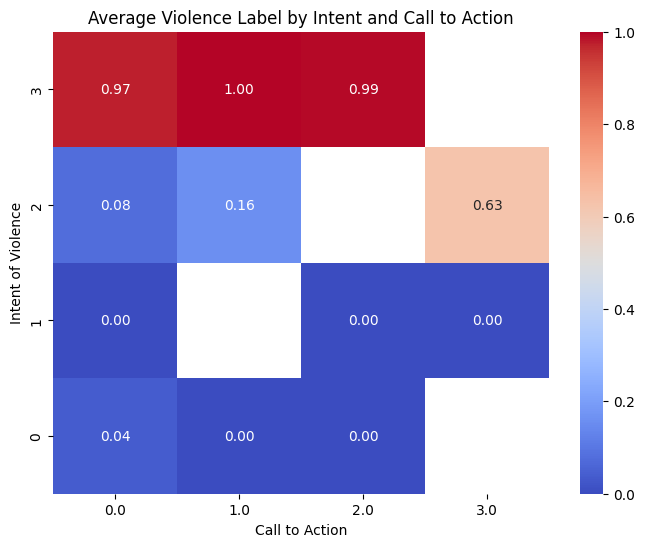

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by intent and call_to_action
heatmap_data = context_small.groupby(['intent_numeric', 'call_to_action_numeric'])['violence_label'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
ax.set_title('Average Violence Label by Intent and Call to Action')
ax.set_xlabel('Call to Action')
ax.set_ylabel('Intent of Violence')
ax.invert_yaxis()


plt.show()

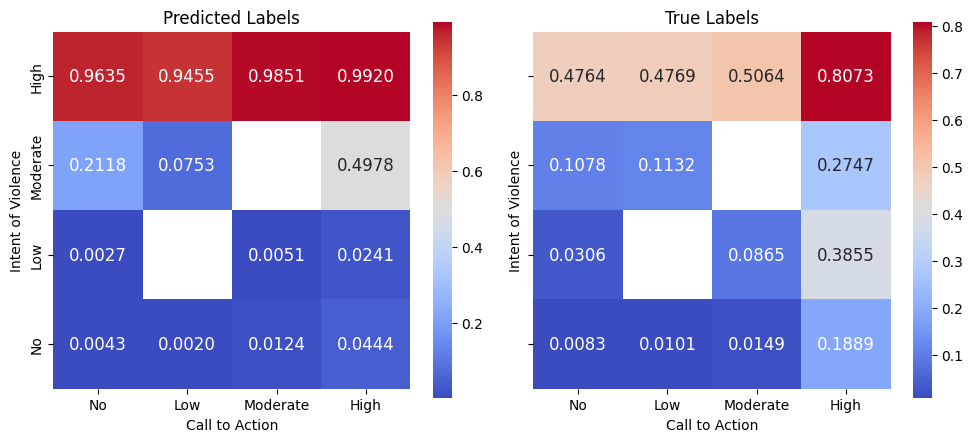

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt

# Group by intent and call-to-action numeric values
heatmap_data_predicted = combined_agents_only.groupby(['intent_numeric', 'call_to_action_numeric'])['violence_label'].mean().unstack()
heatmap_data_true = combined_agents_only.groupby(['intent_numeric', 'call_to_action_numeric'])['true_label'].mean().unstack()


labels = ["No", "Low", "Moderate", "High"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Heatmap: Predicted
sns.heatmap(
    heatmap_data_predicted,
    annot=True,
    cmap='coolwarm',
    fmt=".4f",
    ax=axes[0],
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 12}  # Larger font size in cells
)
axes[0].set_title('Predicted Labels')
axes[0].set_xlabel('Call to Action')
axes[0].set_ylabel('Intent of Violence')
axes[0].invert_yaxis()
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels(labels)

# Heatmap: True
sns.heatmap(
    heatmap_data_true,
    annot=True,
    cmap='coolwarm',
    fmt=".4f",
    ax=axes[1],
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"fontsize": 12}
)
axes[1].set_title('True Labels')
axes[1].set_xlabel('Call to Action')
axes[1].set_ylabel('Intent of Violence')
axes[1].invert_yaxis()
axes[1].set_xticklabels(labels)
axes[1].set_yticklabels(labels)

plt.tight_layout()
plt.show()

In [5]:


# Decode flagged_issues into a proper list
combined_for_all["flagged_issues"] = combined_for_all["flagged_issues"].apply(eval)

# Create binary flags
combined_for_all["has_flag"] = combined_for_all["flagged_issues"].apply(lambda x: len(x) > 0)

# Add correctness column
combined_for_all["is_correct"] = combined_for_all["violence_label"] == combined_for_all["true_label"]


# Decode flagged_issues into a proper list
combined_agents_only["flagged_issues"] = combined_agents_only["flagged_issues"].apply(eval)

# Create binary flags
combined_agents_only["has_flag"] = combined_agents_only["flagged_issues"].apply(lambda x: len(x) > 0)

# Add correctness column
combined_agents_only["is_correct"] = combined_agents_only["violence_label"] == combined_agents_only["true_label"]

In [6]:
flagged_perf = combined_for_all.groupby("has_flag")["is_correct"].mean()
print("Accuracy With and Without Flags:")
print(flagged_perf)


Accuracy With and Without Flags:
has_flag
False    0.825801
True     0.831445
Name: is_correct, dtype: float64


In [7]:
from collections import defaultdict

# Initialize counters
flag_stats = defaultdict(lambda: {"count": 0, "correct": 0})

# Count accuracy for each flag type
for _, row in combined_for_all.iterrows():
    for flag in row["flagged_issues"]:
        flag_stats[flag]["count"] += 1
        if row["is_correct"]:
            flag_stats[flag]["correct"] += 1

# Convert to DataFrame
flag_df = pd.DataFrame({
    flag: {
        "flag_count": stats["count"],
        "accuracy_when_flagged": stats["correct"] / stats["count"] if stats["count"] else 0
    }
    for flag, stats in flag_stats.items()
}).T

print(flag_df)



   flag_count  accuracy_when_flagged
0     62662.0               0.828365
1     24677.0               0.850630
2      1116.0               0.849462
4       170.0               0.788235
3      1168.0               0.581336


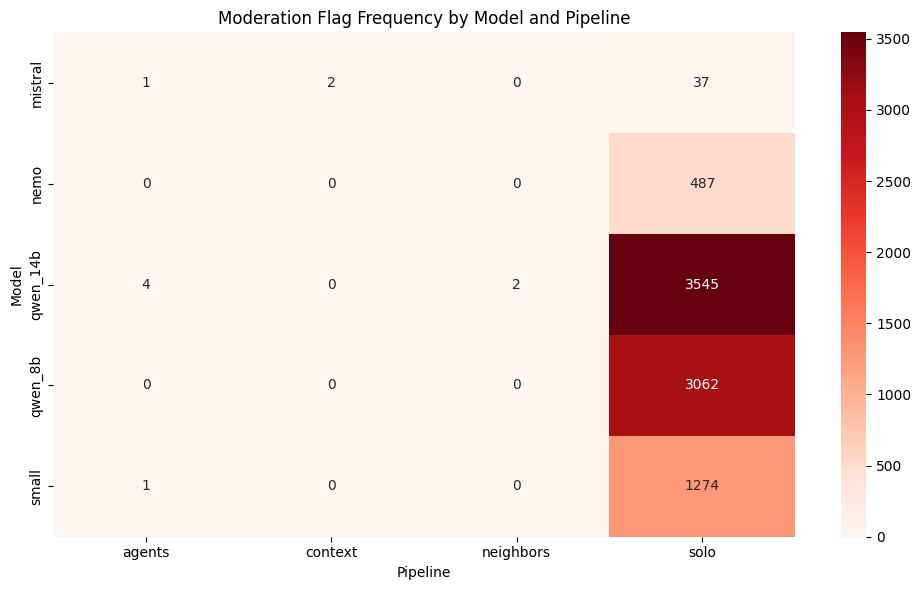

Total anomalous rows: 89775
       document_id       pipe flagged_issues    model
33            1_34  neighbors            [0]  mistral
40            1_41  neighbors            [0]  mistral
50            1_52  neighbors            [0]  mistral
52            1_54  neighbors            [0]  mistral
68            1_70  neighbors            [0]  mistral
...            ...        ...            ...      ...
192595     19_9840    context            [0]    small
192596     19_9841    context            [1]    small
192597     19_9842    context            [1]    small
192598     19_9843    context            [0]    small
192599     19_9844    context            [0]    small

[89775 rows x 4 columns]


In [10]:



# moderations = combined_for_all[combined_for_all["flagged_issues"].apply(lambda flags: 3 in flags)]


# # Create a frequency table of model-pipeline combinations
# model_pipe_matrix = moderations.groupby(['model', 'pipe']).size().unstack(fill_value=0)

# # Plot as heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(model_pipe_matrix, annot=True, cmap="Reds", fmt="d")
# plt.title("Moderation Flag (3) Frequency by Model and Pipeline")
# plt.xlabel("Pipeline")
# plt.ylabel("Model")
# plt.tight_layout()
# plt.show()

def is_moderation_flag(row):
    if row["pipe"] == "solo":
        return 1 in row["flagged_issues"]
    else:
        return 3 in row["flagged_issues"]

# Apply the filter
moderations = combined_for_all[combined_for_all.apply(is_moderation_flag, axis=1)]

# Create a frequency table of model-pipeline combinations
model_pipe_matrix = moderations.groupby(['model', 'pipe']).size().unstack(fill_value=0)

# Plot as heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(model_pipe_matrix, annot=True, cmap="Reds", fmt="d")
plt.title("Moderation Flag Frequency by Model and Pipeline")
plt.xlabel("Pipeline")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


# Define allowed flags per pipeline
allowed_flags = {
    "solo": {"0", "1"},
    "default": {"0", "1", "2", "3"},
}

# Function to detect invalid flags
def has_invalid_flags(row):
    pipe = row["pipe"]
    flags = set(row["flagged_issues"])
    allowed = allowed_flags["solo"] if pipe == "solo" else allowed_flags["default"]
    return not flags.issubset(allowed)

# Filter for rows with invalid flags
anomalies = combined_for_all[combined_for_all.apply(has_invalid_flags, axis=1)]

# Show the anomalies
print(f"Total anomalous rows: {len(anomalies)}")
print(anomalies[["document_id", "pipe", "flagged_issues", "model"]])


In [ ]:
# Group by model only (across all pipelines)
model_performance = (
    combined_for_all
    .groupby("model")
    .agg(
        total_instances=("violence_label", "count"),
        accuracy=("is_correct", "mean"),
        true_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum()),
        false_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 0)).sum()),
        false_negatives=("violence_label", lambda x: ((x == 0) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum())
    )
    .reset_index()
)

# Compute precision, recall, F1
model_performance["precision"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_positives"])
model_performance["recall"] = model_performance["true_positives"] / (model_performance["true_positives"] + model_performance["false_negatives"])
model_performance["f1_score"] = 2 * (model_performance["precision"] * model_performance["recall"]) / (model_performance["precision"] + model_performance["recall"])

# Replace NaNs with 0
model_performance = model_performance.fillna(0)

# Display sorted by F1-score
print(model_performance.sort_values("f1_score", ascending=False))

      model  total_instances  accuracy  true_positives  false_positives  \
4     small            38520  0.880426            2596             2153   
2  qwen_14b            38520  0.823416            3501             5254   
1      nemo            38520  0.822222            3451             5250   
3   qwen_8b            38520  0.817913            3183             5148   
0   mistral            38520  0.798183            3179             5904   

   false_negatives  precision    recall  f1_score  
4             2453   0.546641  0.514161  0.529904  
2             1548   0.399886  0.693405  0.507244  
1             1598   0.396621  0.683502  0.501964  
3             1866   0.382067  0.630422  0.475785  
0             1870   0.349994  0.629630  0.449901  


In [ ]:
# Group by pipeline only
pipeline_performance = (
    combined_for_all
    .groupby("pipe")
    .agg(
        total_instances=("violence_label", "count"),
        accuracy=("is_correct", "mean"),
        true_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum()),
        false_positives=("violence_label", lambda x: ((x == 1) & (combined_for_all.loc[x.index, "true_label"] == 0)).sum()),
        false_negatives=("violence_label", lambda x: ((x == 0) & (combined_for_all.loc[x.index, "true_label"] == 1)).sum())
    )
    .reset_index()
)

# Compute precision, recall, F1
pipeline_performance["precision"] = pipeline_performance["true_positives"] / (pipeline_performance["true_positives"] + pipeline_performance["false_positives"])
pipeline_performance["recall"] = pipeline_performance["true_positives"] / (pipeline_performance["true_positives"] + pipeline_performance["false_negatives"])
pipeline_performance["f1_score"] = 2 * (pipeline_performance["precision"] * pipeline_performance["recall"]) / (pipeline_performance["precision"] + pipeline_performance["recall"])

# Clean up
pipeline_performance = pipeline_performance.fillna(0)

# Show table
print(pipeline_performance.sort_values("f1_score", ascending=False))

        pipe  total_instances  accuracy  true_positives  false_positives  \
0     agents            48150  0.882555            4581             3936   
2  neighbors            48150  0.862181            4786             5122   
1    context            48150  0.845192            5043             6197   
3       solo            48150  0.723801            1500             8454   

   false_negatives  precision    recall  f1_score  
0             1719   0.537865  0.727143  0.618344  
2             1514   0.483044  0.759683  0.590573  
1             1257   0.448665  0.800476  0.575029  
3             4845   0.150693  0.236407  0.184060  
